# Gesture Recognition
In this group project, we have build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [41]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
%matplotlib inline

We have set the random seed so that the results don't vary drastically.

In [42]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, we read the folder names for training and validation. We also set the `batch_size` here. Note that we set the batch size in such a way that we are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [43]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Analysing Data

In [44]:
import matplotlib
import matplotlib.pyplot as plt

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


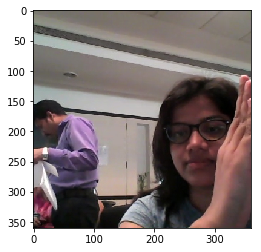

In [45]:
# Taking a random image
image = imread("Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00018.png")
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.show()

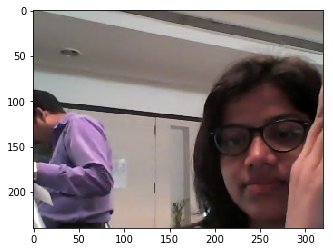

In [46]:
# Checking if we can reterive important data after cropping
imageTry = image[60:300,20:340,:] # cropping 60 pixels each from top and bottom and 20 pixels each from left and right
matplotlib.pyplot.imshow(imageTry)
matplotlib.pyplot.show()

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


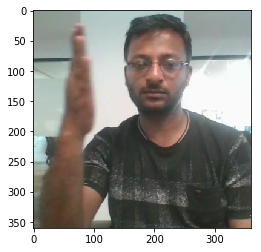

In [47]:
# Cecking another image
image = imread("Project_data/train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_38_17_Pro_00067.png")
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.show()

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


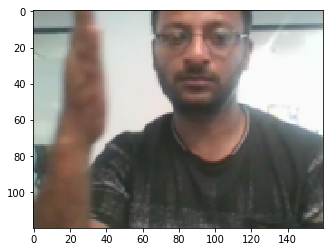

In [48]:
# Checking cropped and resized image
imageTry = imresize(image[60:300,20:340,:], size=(120,160))
matplotlib.pyplot.imshow(imageTry)
matplotlib.pyplot.show()

In [49]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


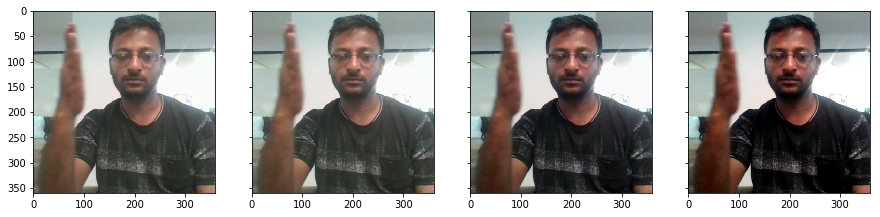

In [50]:
# Checking various normilizing technique
image1 = image.astype('float64')/255

image2 = image.astype('float64') 
image2[:,:,0] = (image2[:,:,0] - np.min(image2[:,:,0]))/(np.max(image2[:,:,0]) - np.min(image2[:,:,0]))
image2[:,:,1] = (image2[:,:,1] - np.min(image2[:,:,1]))/(np.max(image2[:,:,1]) - np.min(image2[:,:,1]))
image2[:,:,2] = (image2[:,:,2] - np.min(image2[:,:,2]))/(np.max(image2[:,:,2]) - np.min(image2[:,:,2]))

image3 = image.astype('float64') 
image3[:,:,0] = (image3[:,:,0] - np.percentile(image3[:,:,0],5))/ (np.percentile(image3[:,:,0],95) - np.percentile(image3[:,:,0],5))
image3[:,:,1] = (image3[:,:,1] - np.percentile(image3[:,:,1],5))/ (np.percentile(image3[:,:,1],95) - np.percentile(image3[:,:,1],5))
image3[:,:,2] = (image3[:,:,2] - np.percentile(image3[:,:,2],5))/ (np.percentile(image3[:,:,2],95) - np.percentile(image3[:,:,2],5))

plot_image([image, image1, image2, image3])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [51]:
x = 30 # x is the number of images you use for each video
y = 120; z = 160; # (y,z) is the final size of the input images
channel = 3 #RGB
classes = 5 #5 gestures

In [52]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,x)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = temp[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = temp[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = temp[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = temp[:,:,0]
                    batch_data[folder,idx,:,:,1] = temp[:,:,1]
                    batch_data[folder,idx,:,:,2] = temp[:,:,2]
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [53]:
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here we have made the model using different functionalities that Keras provides. Remember we are using `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We have used `TimeDistributed` while building a Conv2D + RNN model. Also the last layer is the softmax. We have designed the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [54]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [55]:
# Function to plot the model's accuracy data.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

### 1- CNN 3D

In [56]:
#write your model here

model = Sequential()
model.add(Conv3D(8, (3,3,3), padding='same', input_shape=(x, y, z, channel)))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, (3,3,3), padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3,3,3), padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3),  padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [57]:
optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 160, 8)   656       
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 160, 8)   0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 120, 160, 8)   32        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 80, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 80, 16)    3472      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 80, 16)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 60, 80, 16)    64        
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [58]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [59]:
curr_dt_time = datetime.datetime.now()
model_name = 'CNN-3D_model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0001, factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [61]:
#Fit the model and store the outcome data

result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val Source path =  Project_data/train ; batch size = 30
; batch size = 30
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/23 [=>............................] - ETA: 2:49 - loss: 7.2279 - categorical_accuracy: 0.1333

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 89s 4s/step - loss: 2.6293 - categorical_accuracy: 0.3714 - val_loss: 1.4236 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to CNN-3D_model_init_2020-11-0205_40_19.302298/model-00001-2.71852-0.34691-1.42363-0.46000.h5
Epoch 2/50
23/23 [==============================] - 7s 299ms/step - loss: 3.8114 - categorical_accuracy: 0.2464 - val_loss: 3.5267 - val_categorical_accuracy: 0.2250

Epoch 00002: saving model to CNN-3D_model_init_2020-11-0205_40_19.302298/model-00002-3.81143-0.24638-3.52668-0.22500.h5
Epoch 3/50
23/23 [==============================] - 11s 468ms/step - loss: 2.2512 - categorical_accuracy: 0.3333 - val_loss: 1.9574 - val_categorical_accuracy: 0.2750

Epoch 00003: saving model to CNN-3D_model_init_2020-11-0205_40_19.302298/model-00003-2.25116-0.33333-1.95737-0.27500.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/50
23/23 [==============================] - 9s 393ms/step - los

23/23 [==============================] - 10s 441ms/step - loss: 0.9355 - categorical_accuracy: 0.6667 - val_loss: 0.9496 - val_categorical_accuracy: 0.5750

Epoch 00027: saving model to CNN-3D_model_init_2020-11-0205_40_19.302298/model-00027-0.93550-0.66667-0.94958-0.57500.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 28/50
23/23 [==============================] - 9s 404ms/step - loss: 0.7592 - categorical_accuracy: 0.7101 - val_loss: 0.8183 - val_categorical_accuracy: 0.7250

Epoch 00028: saving model to CNN-3D_model_init_2020-11-0205_40_19.302298/model-00028-0.75923-0.71014-0.81827-0.72500.h5
Epoch 29/50
23/23 [==============================] - 9s 381ms/step - loss: 0.8869 - categorical_accuracy: 0.6812 - val_loss: 0.9431 - val_categorical_accuracy: 0.6250

Epoch 00029: saving model to CNN-3D_model_init_2020-11-0205_40_19.302298/model-00029-0.88691-0.68116-0.94306-0.62500.h5
Epoch 30/50
23/23 [==============================] - 9s 376ms/ste

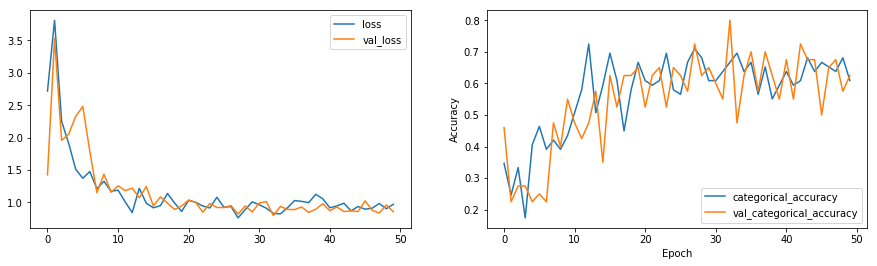

In [62]:
# Call plot method to plot this model's accuracy.
plot(result)

### 2- Using CNN and RNN


In [63]:
# Import libraries
from keras.applications import mobilenet
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

In [64]:
# Initiakize the required parameters
batch_size = 10
num_epochs = 50
x = 30 # # x is the number of images
y = 120 # width of the image
z = 160 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [65]:
# Model declaration

model_2 = Sequential()
model_2.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))

model_2.add(GRU(128))
model_2.add(Dropout(0.25))

model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(classes, activation='softmax'))

In [66]:
# get taraning and validation data from generators
train_generator2 = generator(train_path, train_doc, batch_size)
val_generator2 = generator(val_path, val_doc, batch_size)

# initiaize optimizer
optimiser = 'SGD' #write your optimizer

#compile model 
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 5, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 2, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 2048)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               835968    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
__________

In [67]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'RNN_model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0001, factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [68]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [69]:
# Fit the model and store the result data in a variable for further use.

result2 = model_2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


56/67 [========================>.....] - ETA: 19s - loss: 1.4082 - categorical_accuracy: 0.3929Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 120s 2s/step - loss: 1.3422 - categorical_accuracy: 0.4263 - val_loss: 0.7745 - val_categorical_accuracy: 0.7400

Epoch 00001: saving model to model_init_2020-11-0205_49_53.008171/RNN_model-00001-1.34823-0.42383-0.77449-0.74000.h5
Epoch 2/50
67/67 [==============================] - 38s 563ms/step - loss: 1.0855 - categorical_accuracy: 0.5323 - val_loss: 0.9060 - val_categorical_accuracy: 0.6800

Epoch 00002: saving model to model_init_2020-11-0205_49_53.008171/RNN_model-00002-1.08549-0.53234-0.90602-0.68000.h5
Epoch 3/50
67/67 [==============================] - 38s 563ms/step - loss: 1.1991 - categorical_accuracy: 0.5075 - val_loss: 0.9158 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-11-0205_49_53.008171/RNN_model-00003-1.19909-0.50746-0.91583-0.69000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/50
67/67 [==============================] - 38s 565ms/step - loss: 0.9

67/67 [==============================] - 38s 564ms/step - loss: 0.0721 - categorical_accuracy: 0.9950 - val_loss: 0.2818 - val_categorical_accuracy: 0.8700

Epoch 00028: saving model to model_init_2020-11-0205_49_53.008171/RNN_model-00028-0.07215-0.99502-0.28181-0.87000.h5
Epoch 29/50
67/67 [==============================] - 38s 563ms/step - loss: 0.1041 - categorical_accuracy: 0.9851 - val_loss: 0.2842 - val_categorical_accuracy: 0.8800

Epoch 00029: saving model to model_init_2020-11-0205_49_53.008171/RNN_model-00029-0.10409-0.98507-0.28416-0.88000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 30/50
67/67 [==============================] - 38s 563ms/step - loss: 0.1505 - categorical_accuracy: 0.9502 - val_loss: 0.2832 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2020-11-0205_49_53.008171/RNN_model-00030-0.15052-0.95025-0.28317-0.87000.h5
Epoch 31/50
67/67 [==============================] - 38s 563ms/step - lo

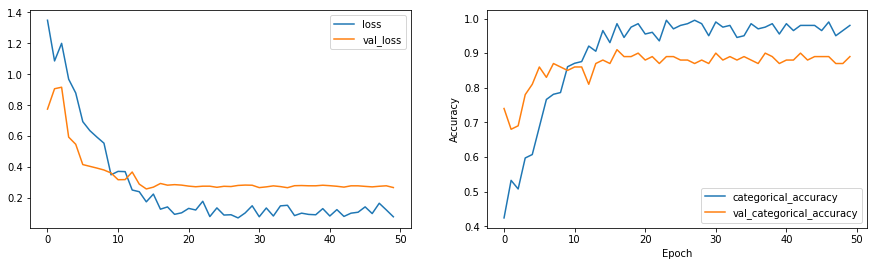

In [70]:
# plot the model accuracy data
plot(result2)